# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 4: Alternative Word Embeddings

This notebook contains code to explore alternative word embeddings.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)

## Importing of Libraries

In [246]:
import pandas as pd
import numpy as np

from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict

TRAIN_SET_PATH = "../assets/train_prep.csv"

GLOVE_6B_50D_PATH = "../assets/glove.6B.50d.txt"
GLOVE_6B_300D_PATH = "../assets/glove.6B.300d.txt"
encoding="utf-8"

BERT_INIT_CHKPNT = "../assets/cased_L-12_H-768_A-12/bert.model.ckpt.index"
BERT_VOCAB = "../assets/cased_L-12_H-768_A-12/vocab.txt"
BERT_CONFIG = "../assets/cased_L-12_H-768_A-12/bert_config.json"

from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
# import tensorflow as tf
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_hub as hub

from wordcloud import WordCloud

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Import

In [180]:
# Import 'train_prep' and 'test_prep' datasets
# We use the 'keep_default_na' option to False to ensure that pandas does not re-introduce missing values
train = pd.read_csv("../assets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_prep.csv", keep_default_na=False)

In [181]:
train.shape, test.shape

((3321, 10119), (5668, 10118))

In [182]:
train.head(2)

id  class  \
0   0      1   
1   1      2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [183]:
test.head(2)

id  \
0   0   
1   1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Splitting of data into Predictor (X) and Target (y) Dataframes

In [184]:
X = train[[i for i in train.columns if i not in ['id', 'class']]]
y = train['class']

In [185]:
X.shape, y.shape

((3321, 10117), (3321,))

In [186]:
# Save copies of the original X and y dataframes so that we can try different word embeddings as needed
X_original = X.copy()
y_original = y.copy()

## Evaluation of Alternative Static Word Embeddings

We will explore three alternative static word embeddings to see if we can get better classification results:
1. GloVe (Global Vectors for Word Representation) pre-trained word vectors based on Wikipedia 2015 and Gigaword 5th Edition (https://catalog.ldc.upenn.edu/LDC2011T07) - we create a dictionary called 'glove_small' for these word vectors.
2. GloVe pre-trained word vectors based on Common Crawl (https://commoncrawl.org/) - we create a dictionary called 'glove_big' for these word vectors.
3. Our own word vectors trained using Word2Vec from nltk, based on all the given text in the training dataset - we create a dictionary called 'w2v' for these word vectors.

The GloVe word vectors are created by the [Stanford Natural Language Processing Group](https://nlp.stanford.edu/) and are available at https://nlp.stanford.edu/projects/glove/.

In [187]:
%%time
# For convenience, we create an array called 'X_all_text that contains
# all the text from our training set, across all data points
X_all_text = []
for text in X['text']:
    X_all_text.append(text.split())
X_all_text = np.array(X_all_text)

Wall time: 5.02 s


In [188]:
# %%time
# with open(GLOVE_6B_50D_PATH, "rb") as lines:
#     wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32) for line in lines}

Wall time: 12.3 s


We now load the two pre-trained word vectors (based on GloVe) and store them as dictionary objects 'glove_small' and 'glove_big'.

In [191]:
%%time
import struct 

# glove_small keys are bounded by what is common to both the X_all_text and the glove file
glove_small = {}
all_words = set(w for words in X_all_text for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

# glove_big keys are bounded by what is common to both the X_all_text and the glove file
glove_big = {}
with open(GLOVE_6B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

Wall time: 21.9 s


We now create our own word vectors using Word2Vec from nltk, trained using all the text in the training dataset.

In [192]:
%%time
model = Word2Vec(X_all_text, size=100, window=5, min_count=5, workers=8)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

Wall time: 1min 59s


In [193]:
print("Number of unique words used for training Word2Vec: {}".format(len(all_words)))

Number of unique words used for training Word2Vec: 81318


We define two word embedding vectorizers - as variations of the CountVectorizer and TfidfVectorizer - that take a word-to-vector mapping and vectorises the text by taking the **mean** of all the 'glove_small' vectors corresponding to individual words.

In [207]:
class MeanEmbeddingVectorizer(object):
    
    # Creating a new MeanEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create a new array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    # The 'fit' method simply returns the input parameter 'word2vec' itself
    def fit(self, X, y):
        return self 

    # The 'transform' method returns an array consisting of the mean of all
    # 'glove_small" vectors that correspond to individual words in the input parameter 'X'
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# TfidfVectorizer is a variation of the Term Frequency - Inverse Document Frequency (Tfidf) Vectorizer
class TfidfEmbeddingVectorizer(object):

    
    # Creating a new TfidfEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create an array of size eequal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    # The 'fit' method updates the word weights attribute based on the
    # output of the standard TfidfVectorizer
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    # The 'transform' method returns an array consisting of the mean of all 'glove_small'
    # vecotrs (adjusted by the Tfidf weights) that correspond to individual words
    # in the input parameter 'X'
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

We create multiple pipelines that cover different combinations of the Vectorizers we have defined and the word embeddings, coupled with the Extra Trees classifier which is chosen based on its generally good performance; it produces less variance but may cause an increase in bias, compared to a Random Forest classifier. The combinations are as follows:
- mev_w2v: MeanEmbeddingVectorizer based on our own 'w2v' word vectors created using Word2Vec on the words in the training dataset
- tev_w2v: TfidfEmbeddingVectorizer based on our own 'w2v word vectors
- mev_glove_small: MeanEmbeddingVectorizer based on the 'glove_small' word vectors
- tev_glove_small: TfidfEmbeddingVectorizer based on the 'glove_small' word vectors
- mev_glove_big: MeanEmbeddingVectorizer based on the 'glove_big' word vectors
- tev_glove_big: TfidfEmbeddingVectorizer based on the 'glove_big' word vectors

In [208]:
# Create the various pipelines for evaluation
mev_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_small = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_big = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])

We now obtain the 5-fold cross-validation accuracy scores for each pipeline based on the labels 'y' (i.e. variation classes), and sort them in descending order of cross-validation accuracy score.

In [210]:
%%time
all_models = [
    ("mev_w2v", mev_w2v),
    ("tev_w2v", tev_w2v),
    ("mev_glove_small", mev_glove_small),
    ("tev_glove_small", tev_glove_small),
    ("mev_glove_big", mev_glove_big),
    ("tev_glove_big", tev_glove_big)
]

unsorted_scores = [(name, cross_val_score(model, X_all_text, y, cv=5, n_jobs=-1).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print (tabulate(scores, floatfmt=".4f", headers=("Model", 'Cross-Validation Accuracy Score')))

Model              Cross-Validation Accuracy Score
---------------  ---------------------------------
mev_w2v                                     0.4785
tev_w2v                                     0.4577
mev_glove_big                               0.4378
mev_glove_small                             0.4336
tev_glove_big                               0.4222
tev_glove_small                             0.4035
Wall time: 20min 24s


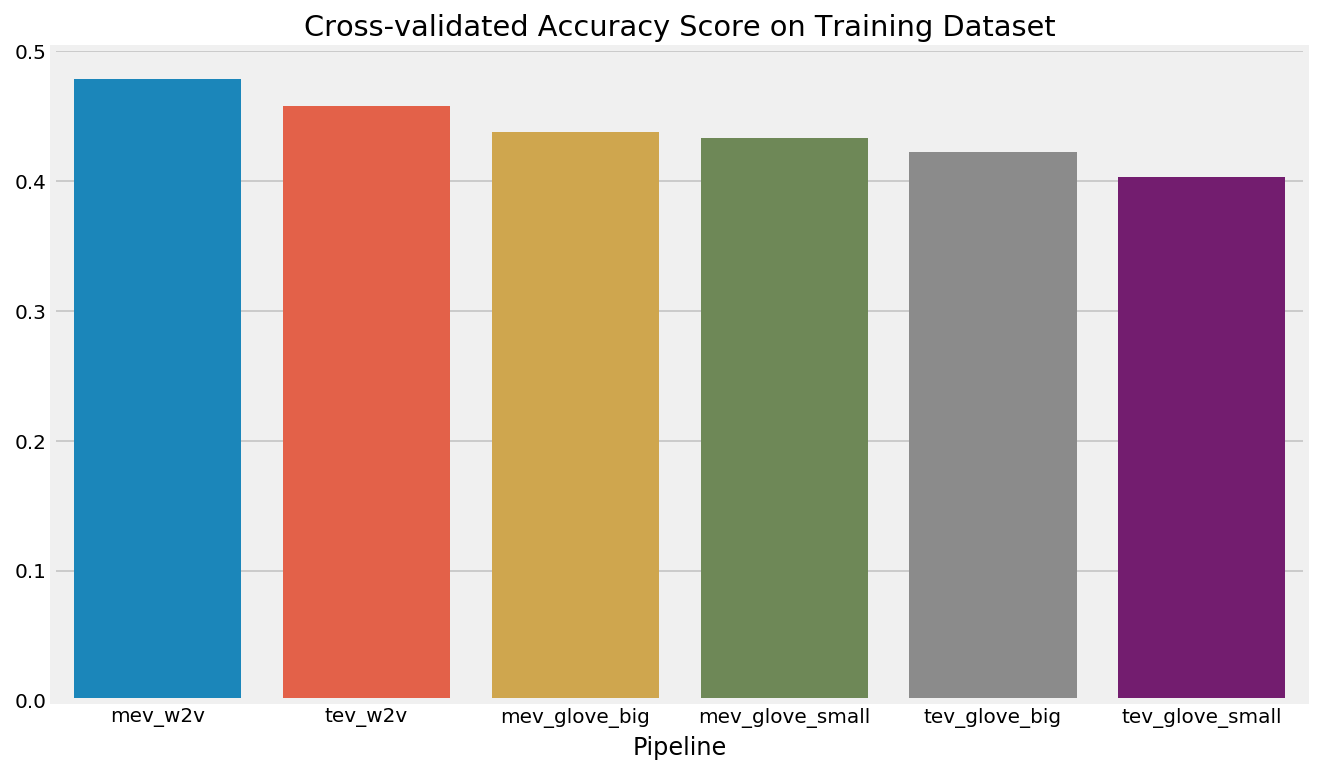

In [211]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores]);
plt.title("Cross-validated Accuracy Score on Training Dataset")
plt.xlabel("Pipeline");

As shown above, the Mean Embedding Vectorizer (mev) performs best together with the Word2Vec (w2v) word embedding, as it scores the highest in terms of the cross-validated accuracy score.

For the baseline model, we had used the Count Vectorizer to create the vectors for the training set. This time, we will use the Mean Embedding Vectorizer based on the Word2Vev word embeddings. We will subsequently find the best classifier, as per the approach for finding the baseline classifier.

## Evaluation of Mean Embedding Vectorizer, Word2Vec Embeddings and Extra Trees Classifier

### Creation of (Inner) Training and Validation Datasets

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [212]:
# Restore the original predictor and target dataframes
X = X_original.copy()
y = y_original.copy()

In [213]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [214]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 10117), (2490,), (831, 10117), (831,))

In [215]:
# Reset the indices to prevent spurious rows from appearing later during merging
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

### Tokenisation using Mean Embedding Vectorizer with Word2Vec Word Embeddings

In [216]:
# Instantiate a Mean Embedding Vectorizer object using the Word2Vec word embeddings
mev = MeanEmbeddingVectorizer(w2v)

In [217]:
%%time
X_train_mev = mev.fit(X_train['text'], y_train)
X_train_mev = mev.transform(X_train['text'])
X_val_mev = mev.transform(X_val['text'])

Wall time: 1min 38s


In [218]:
X_train_mev.shape, X_val_mev.shape

((2490, 100), (831, 100))

In [219]:
X_train_mev_df = pd.DataFrame(X_train_mev)
X_val_mev_df = pd.DataFrame(X_val_mev)

In [220]:
X_train_mev_df.shape, X_val_mev_df.shape

((2490, 100), (831, 100))

In [221]:
X_train_mev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.015932,0.021378,-0.859686,0.100560,1.827435,-1.287603,1.058708,0.756118,-0.304338,-0.767960,...,-0.154870,-0.913400,-2.522630,0.455832,1.127669,-0.972328,-1.435042,-1.457444,1.871018,-0.792210
1,0.092930,0.014491,-1.030104,0.043443,1.957839,-1.271200,1.012892,0.749768,-0.316686,-0.670070,...,-0.120599,-0.985288,-2.672418,0.621184,1.078377,-0.996480,-1.330879,-1.403869,1.927013,-0.764254
2,0.086019,-0.011209,-0.926502,0.122302,1.916721,-1.233710,1.174277,0.847769,-0.336526,-0.760065,...,-0.086419,-0.843886,-2.623507,0.466064,1.133875,-1.026994,-1.360336,-1.430486,1.953416,-0.836043
3,0.042683,-0.025387,-0.965116,0.096169,1.906812,-1.203487,1.023132,0.715771,-0.310148,-0.707276,...,-0.150568,-0.959041,-2.591181,0.561080,1.094723,-1.027202,-1.384818,-1.393969,1.898411,-0.808574
4,0.049261,0.039102,-0.941646,0.062423,1.887837,-1.224875,1.051974,0.712371,-0.323565,-0.749294,...,-0.126075,-0.950439,-2.560685,0.538552,1.104855,-0.960758,-1.408779,-1.454514,1.843283,-0.825829


In [222]:
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_mev_df], axis=1)
X_val = pd.concat([X_val, X_val_mev_df], axis=1)

In [223]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)

In [224]:
X_train.shape, X_val.shape

((2490, 10216), (831, 10216))

In [225]:
X_train.head()

,gene_A4GALT,gene_AAAS,gene_AANAT,gene_AARS,gene_ABCA1,gene_ABCA12,gene_ABCA3,gene_ABCA4,gene_ABCB11,gene_ABCB7,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,-0.154870,-0.913400,-2.522630,0.455832,1.127669,-0.972328,-1.435042,-1.457444,1.871018,-0.792210
1,0,0,0,0,0,0,0,0,0,0,...,-0.120599,-0.985288,-2.672418,0.621184,1.078377,-0.996480,-1.330879,-1.403869,1.927013,-0.764254
2,0,0,0,0,0,0,0,0,0,0,...,-0.086419,-0.843886,-2.623507,0.466064,1.133875,-1.026994,-1.360336,-1.430486,1.953416,-0.836043
3,0,0,0,0,0,0,0,0,0,0,...,-0.150568,-0.959041,-2.591181,0.561080,1.094723,-1.027202,-1.384818,-1.393969,1.898411,-0.808574
4,0,0,0,0,0,0,0,0,0,0,...,-0.126075,-0.950439,-2.560685,0.538552,1.104855,-0.960758,-1.408779,-1.454514,1.843283,-0.825829


### Randomised Search for optimal Extra Trees classifier parameters

To manage the total time and resources used to tune the classifier parameters, we use the RandomizedSearchCV to find the optimum parameters for the Extra Trees classifier to give the best 3-way cross-validated accuracy score on the training set, within a maximum of 10 iterations. We did not consider other classifiers due to the limitations of processing power and memory. Additional classifiers could be evaluated as a next step to this Capstone project, akin to the range of classifiers that were evaluated to find the baseline classifier.

In [226]:
# We have selected the models below for modelling purposes.
estimators = {
    'etree': ExtraTreesClassifier(random_state=42),
}.items()

In [227]:
params = {
    'etree': {
        'etree__n_estimators': [150, 200, 250],
        'etree__max_features': ['auto', 'sqrt', 'log2', None],
        'etree__min_samples_split': [4, 6, 8],
        'etree__min_samples_leaf': [2, 3, 4]
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best mean cross-validated accuracy score based on the training dataset.

In [228]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
train_accuracy = []
val_accuracy = []
best_score = []
train_roc_auc = []
val_roc_auc = []
sensitivity = []

for k,v in estimators:
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter=10, # we set a max. of 10 iterations
        estimator=pipe,
        random_state=42,
        param_distributions=param,
        verbose=1,
        cv= 5,
        # We limit the no. of jobs to ensure sufficient memory for successful execution
        n_jobs=-1,
        return_train_score= True,
        # RandomizedSearchCV will use best cross-validation accuracy score to determine best parameters
        scoring = 'accuracy' 
    )

    randomsearch.fit(X_train, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # print results
    print ("Model: ", k)
    print ("Best parameters:", best_params)
    print ("Best accuracy cross validation score:", randomsearch.best_score_)
    print ("Training dataset accuracy:", accuracy_score(y_train,y_pred_train))
    print ("Validation dataset accuracy:", accuracy_score(y_val,y_pred_val))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_accuracy.append(accuracy_score(y_train,y_pred_train))
    val_accuracy.append(accuracy_score(y_val,y_pred_val))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.4min finished


Model:  etree
Best parameters: {'etree__n_estimators': 250, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 2, 'etree__max_features': None}
Best accuracy cross validation score: 0.6594377510040161
Training dataset accuracy: 0.9080321285140562
Validation dataset accuracy: 0.6474127557160048

Wall time: 12min 9s


In [229]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best accuracy cross validation score': best_score,
    'Training dataset accuracy': train_accuracy,
    'Validation dataset accuracy': val_accuracy
    })

pd.set_option('display.max_colwidth', None)
summary.sort_values('Validation dataset accuracy', ascending=False).reset_index(drop=True)

,model,parameters,Best accuracy cross validation score,Training dataset accuracy,Validation dataset accuracy
0,etree,"{'etree__n_estimators': 250, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 2, 'etree__max_features': None}",0.659438,0.908032,0.647413


We note that the training the classifier based on the given text alone did not yield a better result than the baseline model, even when usng a word vector approach.

## Evaluation of Contextualised Word Embeddings

We now turn our attention to the use of contextualised word embeddings - in particular ELMo (Embeddings from Language Models) - to determine their usefulness in our classification problem.

In [250]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

RuntimeError: variable_scope module_4/ was unused but the corresponding name_scope was already taken.

## Tokenisation using BERT

In [13]:
X.head()

,id,text,gene_ABL1,gene_ACVR1,gene_AGO2,gene_AKT1,gene_AKT2,gene_AKT3,gene_ALK,gene_APC,...,variation_Y87N,variation_Y901C,variation_Y931C,variation_Y98H,variation_Y98N,variation_YAP1-FAM118B Fusion,variation_YAP1-MAMLD1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_p61BRAF
0,0,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,abstract background non small lung cancer nscl...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,abstract background non small lung cancer nscl...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,recent evidence ha demonstrated acquired unipa...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,oncogenic monomeric casitas b lineage lymphoma...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [15]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [17]:
# Tokenisation
tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (5876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5004 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5143 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (3934 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1309 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3934 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1717 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (14368 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5716 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (40931 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12150 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (28380 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (5492 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2327 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2710 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7091 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (12412 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5366 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11796 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15530 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (8842 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12886 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3288 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (3929 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2188 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15388 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2684 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (2965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10758 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5266 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15854 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6900 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5405 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3802 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4009 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11467 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7457 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (8664 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7457 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12968 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (5819 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6752 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5838 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9166 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (12357 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4151 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (1514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (25336 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10359 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (37431 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1978 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2123 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (28971 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4284 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (13683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11810 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (23757 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10861 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6083 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9212 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (5925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10412 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (6666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15622 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1368 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3242 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4109 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5757 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3688 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (5013 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8411 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3374 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5037 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (4723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10139 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4239 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10272 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (10621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (3248 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3823 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10104 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15916 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (13364 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4274 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6920 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4976 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4360 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8283 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4262 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11108 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (24054 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4499 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (17918 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (18507 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (29936 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (12943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12890 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9785 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9785 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5044 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4663 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3257 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4663 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3084 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (3474 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4348 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4348 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13645 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14498 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (1697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8286 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10058 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (16301 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (26847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3694 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11882 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (5883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (4253 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6107 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6806 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (5704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6478 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5011 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (3697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (23585 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (9891 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14418 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7509 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (36575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (12705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9907 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9907 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (18050 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9907 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5461 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (1357 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6185 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5743 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4490 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (18387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6064 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4772 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22265 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5237 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (39095 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13157 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11316 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (31171 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (39860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Token indices sequence length is longer than the specified maximum sequence length for this model (10454 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10454 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9985 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10454 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7179 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (8009 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (3801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (9608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4320 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15301 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4320 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (6921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (19176 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22363 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4440 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (8264 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6335 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9225 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9247 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (13726 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6342 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10707 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15502 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7205 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13229 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4759 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6342 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4212 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2103 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (17467 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9879 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11884 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (6615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3264 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8102 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (2926 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3380 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (5371 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9107 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10403 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4328 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4304 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2633 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4414 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4414 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9295 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (5260 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (1302 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13501 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6103 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5217 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (46065 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16715 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4731 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (41525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (19804 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (1651 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22302 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3153 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3234 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (14611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2852 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2067 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3157 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12031 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (24922 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10220 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11998 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6220 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10759 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (24509 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (17241 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (38150 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12153 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (4051 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1411 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6425 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (9102 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

In [ ]:
# Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
# Running our Model
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
X = pd.concat([pd.DataFrame(last_hidden_states[0][:,0,:].numpy()), X], axis=1)
X.drop(columns='text', inplace=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 3262), (2490,), (831, 3262), (831,))

In [15]:
X_train.reset_index(inplace=True)
X_val.reset_index(inplace=True)